Notebook by Jacqueline Lam

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import random
import os

# import tensorflow as tf
import torch
from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

##Load Data

In [ ]:
# df = pd.read_csv("/content/drive/My Drive/frugal_ai/Juliana/df_limited.csv")

In [ ]:
# df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")
# df.head(5)

,quote,label,connection_index,type,set
0,"I, I’m not sure why, uh, people have tried to ...",0_not_relevant,1938,oga,train
1,"Seldom, if ever, in Canadian history has so mu...",0_not_relevant,2975,oga,test
2,What do you think? I’d say [I’ve been] a small...,0_not_relevant,6085,oga,test
3,"Really, given that God does judge nations, it’...",0_not_relevant,3212,oga,train
4,"And then he met Meghan Markle, and it’s fallen...",0_not_relevant,5405,oga,train


In [5]:
df = pd.read_pickle("/content/drive/My Drive/frugal_ai/Jacq/data_vector2.pkl")

In [6]:
df.label.value_counts()

,count
label,
0_not_relevant,568
1_not_happening,568
2_not_human,568
3_not_bad,568
4_solutions_harmful_unnecessary,568
5_science_unreliable,568
6_proponents_biased,568
7_fossil_fuels_needed,568


##Vectorize (Bert Embedding)

In [ ]:
# Set a random seed
random_seed = 123
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Load BERT tokenizer and model
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def bert_embedding(example_sentence, model=model_bert, tokenizer=tokenizer_bert):

  # Tokenize and encode the example sentence
  example_encoding = tokenizer.batch_encode_plus(
      [example_sentence],
      padding=True,
      truncation=True,
      return_tensors='pt',
      add_special_tokens=True
  )
  example_input_ids = example_encoding['input_ids']
  example_attention_mask = example_encoding['attention_mask']

  # Generate embeddings for the example sentence
  with torch.no_grad():
      example_outputs = model(example_input_ids, attention_mask=example_attention_mask)
      example_sentence_embedding = example_outputs.last_hidden_state.mean(dim=1).numpy()

  return example_sentence_embedding

In [ ]:
df['vector_bert'] = df['quote'].apply(bert_embedding)
df.head(5)

,quote,label,connection_index,type,set,vector_bert
0,"I, I’m not sure why, uh, people have tried to ...",0_not_relevant,1938,oga,train,"[[0.3192349, 0.37202504, 0.061069325, 0.142548..."
1,"Seldom, if ever, in Canadian history has so mu...",0_not_relevant,2975,oga,test,"[[-0.33194694, -0.11436532, -0.511136, -0.1179..."
2,What do you think? I’d say [I’ve been] a small...,0_not_relevant,6085,oga,test,"[[0.016604, 0.0834962, 0.19821484, -0.0579791,..."
3,"Really, given that God does judge nations, it’...",0_not_relevant,3212,oga,train,"[[0.12856574, 0.19278924, -0.29652733, -0.2343..."
4,"And then he met Meghan Markle, and it’s fallen...",0_not_relevant,5405,oga,train,"[[0.049800143, 0.08216716, 0.34868148, -0.0175..."


In [ ]:
df.to_pickle("/content/drive/My Drive/frugal_ai/Jacq/data_vector2.pkl")
os.listdir("/content/drive/My Drive/frugal_ai/Jacq/")

['clustering_balanced df.ipynb',
 'data_vector.pkl',
 'data_vector2.pkl',
 'clustering.ipynb']

##Train, Test Split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

train_df.shape, test_df.shape

((3635, 6), (909, 6))

## Cosine Similarity (Embedding)

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
def cosine_sim(a,b):
  similarity_score = cosine_similarity(a, b)[0][0]
  return similarity_score

##Model: centroid similarity

In [10]:
c = train_df.groupby(['label'])['vector_bert'].mean().reset_index()
c.rename(columns={'label':'label_c', 'vector_bert':'vector_c'}, inplace=True)
c

,label_c,vector_c
0,0_not_relevant,"[[-0.005726938, 0.068710364, 0.096021555, 0.02..."
1,1_not_happening,"[[-0.08046377, -0.022559118, 0.32295862, 0.049..."
2,2_not_human,"[[-0.0586784, 0.11133111, 0.22989465, 0.094396..."
3,3_not_bad,"[[-0.006635979, 0.09250191, 0.21454109, 0.1318..."
4,4_solutions_harmful_unnecessary,"[[0.00037935254, 0.06586467, 0.18620853, 0.170..."
5,5_science_unreliable,"[[-0.04980244, 0.14773737, 0.17653622, 0.06768..."
6,6_proponents_biased,"[[0.09881687, 0.12518944, 0.111074895, 0.05005..."
7,7_fossil_fuels_needed,"[[0.032004125, 0.06506321, 0.117509566, 0.1801..."


In [11]:
df2 = test_df.merge(c, how='cross')
df2['similarity'] = df2.apply(lambda x: cosine_sim(x['vector_bert'], x['vector_c']), axis=1)
df2.head()

,quote,label,connection_index,type,set,vector_bert,label_c,vector_c,similarity
0,Even if Canada met it's reduction it would mak...,4_solutions_harmful_unnecessary,703,oga,train,"[[0.11061508, 0.0036095316, 0.3147148, 0.11311...",0_not_relevant,"[[-0.005726938, 0.068710364, 0.096021555, 0.02...",0.767419
1,Even if Canada met it's reduction it would mak...,4_solutions_harmful_unnecessary,703,oga,train,"[[0.11061508, 0.0036095316, 0.3147148, 0.11311...",1_not_happening,"[[-0.08046377, -0.022559118, 0.32295862, 0.049...",0.769335
2,Even if Canada met it's reduction it would mak...,4_solutions_harmful_unnecessary,703,oga,train,"[[0.11061508, 0.0036095316, 0.3147148, 0.11311...",2_not_human,"[[-0.0586784, 0.11133111, 0.22989465, 0.094396...",0.745877
3,Even if Canada met it's reduction it would mak...,4_solutions_harmful_unnecessary,703,oga,train,"[[0.11061508, 0.0036095316, 0.3147148, 0.11311...",3_not_bad,"[[-0.006635979, 0.09250191, 0.21454109, 0.1318...",0.761985
4,Even if Canada met it's reduction it would mak...,4_solutions_harmful_unnecessary,703,oga,train,"[[0.11061508, 0.0036095316, 0.3147148, 0.11311...",4_solutions_harmful_unnecessary,"[[0.00037935254, 0.06586467, 0.18620853, 0.170...",0.784071


In [12]:
maxes = df2.groupby(['quote','label'])['similarity'].idxmax()
result_df = df2.loc[maxes]
result_df.shape

(909, 9)

In [13]:
labels = result_df['label']
pred_labels = result_df['label_c']

(array([  1.,   5.,   3.,  15.,  19.,  39.,  73., 138., 157.,  66.]),
 array([0.67392278, 0.70138991, 0.72885698, 0.75632405, 0.78379118,
        0.81125832, 0.83872539, 0.86619246, 0.89365959, 0.92112672,
        0.9485938 ]),
 <BarContainer object of 10 artists>)

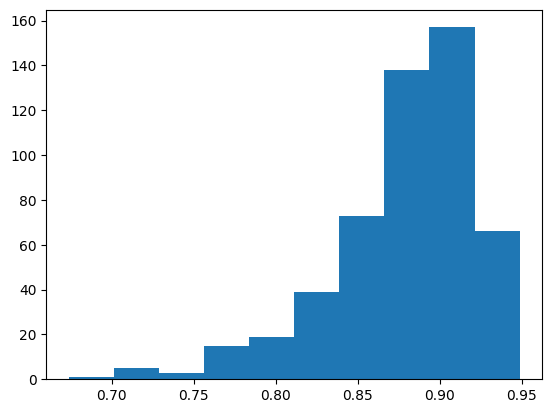

In [18]:
plt.hist(result_df.loc[result_df['label']==result_df['label_c']].similarity)

(array([  1.,   3.,   7.,  12.,  20.,  36.,  64.,  92., 100.,  58.]),
 array([0.69281936, 0.7189666 , 0.74511391, 0.77126116, 0.79740846,
        0.82355571, 0.84970295, 0.87585026, 0.90199751, 0.92814481,
        0.95429206]),
 <BarContainer object of 10 artists>)

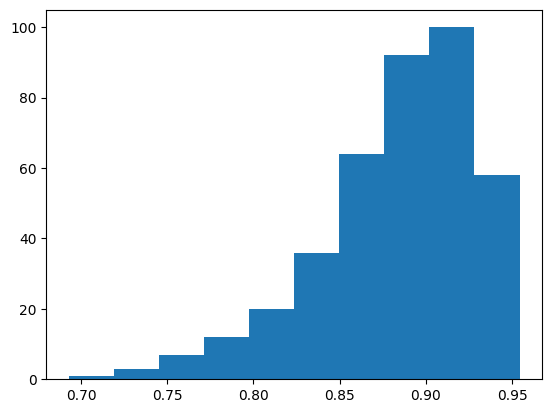

In [19]:
plt.hist(result_df.loc[result_df['label']!=result_df['label_c']].similarity)

##Evaluation

In [ ]:
#result
labels = result_df['label']
pred_labels = result_df['label_c']

print(np.unique(labels))
print(np.unique(pred_labels))

['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']
['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']


Text(50.5815972222222, 0.5, 'True')

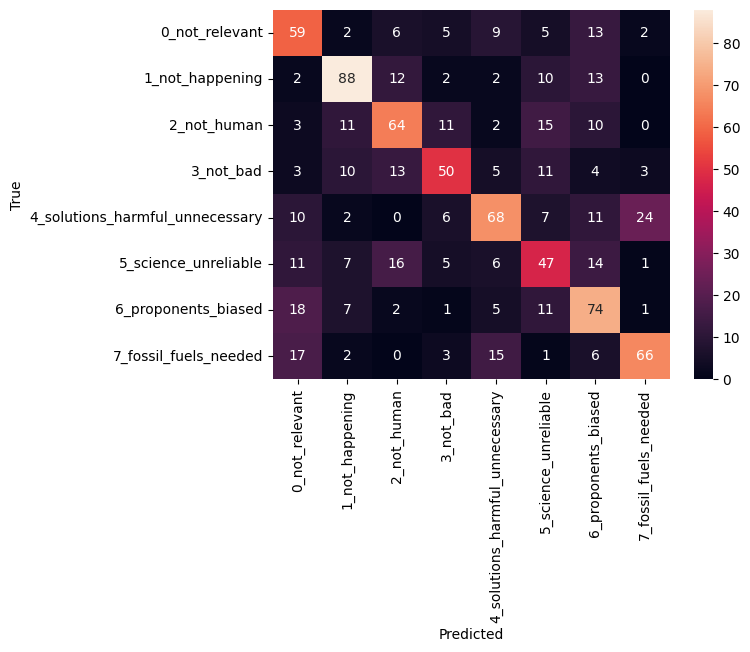

In [ ]:
names=np.unique(labels)
cm = confusion_matrix(labels, pred_labels, labels=names)
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=names,
    yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
print(classification_report(labels, pred_labels, target_names=names, digits=4))

                                 precision    recall  f1-score   support

                 0_not_relevant     0.4797    0.5842    0.5268       101
                1_not_happening     0.6822    0.6822    0.6822       129
                    2_not_human     0.5664    0.5517    0.5590       116
                      3_not_bad     0.6024    0.5051    0.5495        99
4_solutions_harmful_unnecessary     0.6071    0.5312    0.5667       128
           5_science_unreliable     0.4393    0.4393    0.4393       107
            6_proponents_biased     0.5103    0.6218    0.5606       119
          7_fossil_fuels_needed     0.6804    0.6000    0.6377       110

                       accuracy                         0.5677       909
                      macro avg     0.5710    0.5644    0.5652       909
                   weighted avg     0.5743    0.5677    0.5686       909

